<a href="https://colab.research.google.com/github/Thiraput01/My_ML_learning/blob/main/Neural_Net_z_to_h/micrograd_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

# **Graph Building using graphviz**



In [2]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

# **Init Micrograd**

In [3]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value({self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "Data types are not supported"
    out = Value(self.data**other, (self, ), f'**{other}')
    def _backward():
      self.grad += other * (self.data**(other-1)) * out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self * other**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


# **Example usage of micrograd**


In [4]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()


> The code aboves performs an operation ***tanh (x1w1 + x2w2 + b)***




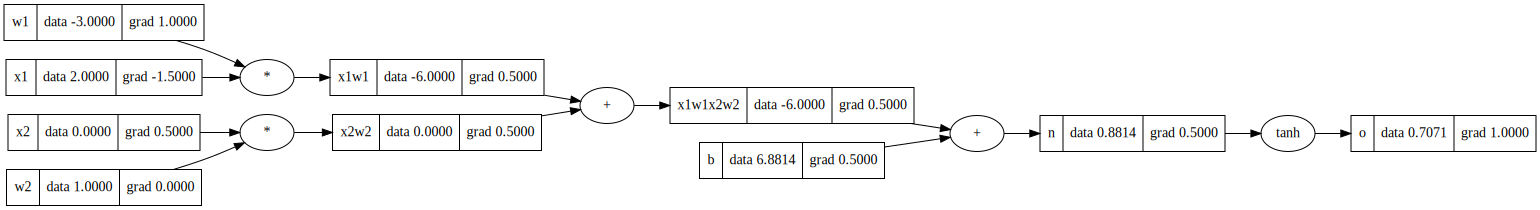

In [5]:
draw_dot(o)

# **Implementing NN by using micrograd as a compute graph**



> Neuron class which represent a single neuron in the network using tanh as an activation function

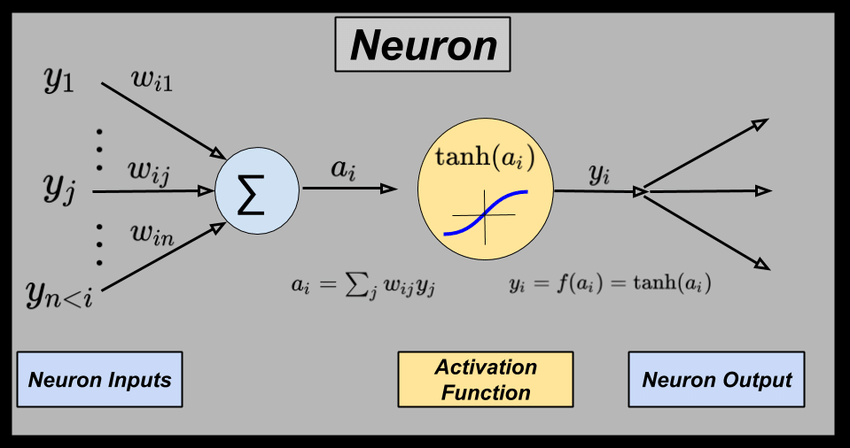



In [6]:
class Neuron:

    def __init__(self, nin):
      # random the weights (uniform dist)between -1 to 1
      self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
      self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
      # wx + b
      act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
      out = act.tanh()
      return out

    def parameters(self):
      return self.w + [self.b]







> Layer class which represent one layer in network which contains list of neurons
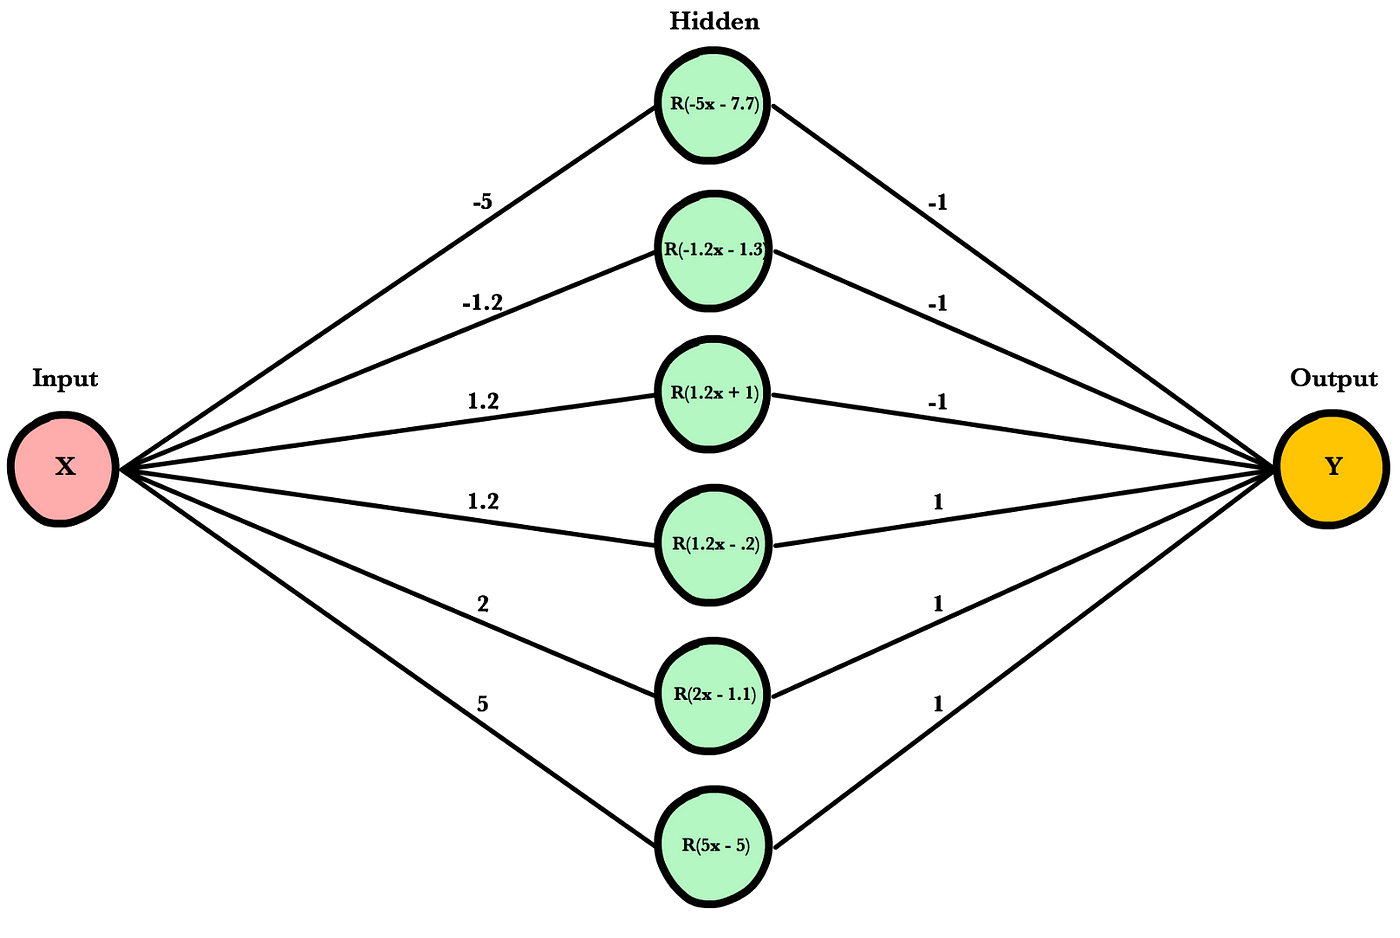


In [7]:
class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]



> MLP (Multilayer perceptron) class which represent the whole neural network systems



In [8]:
class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

# **Example usage of MLP**

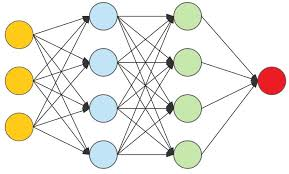

The picture of MLP(3, [4, 4, 1])

In [9]:
x = [2.0, 3.0 -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(0.3254115408096827)

In [10]:
n.parameters()

[Value(-0.6631310017187613),
 Value(0.9654952119222244),
 Value(0.0627478203513947),
 Value(0.5784365645561333),
 Value(-0.33761563550237006),
 Value(0.46038932634678664),
 Value(-0.10482140368342119),
 Value(0.07532833293571928),
 Value(0.4801264949978279),
 Value(0.6218026009011228),
 Value(0.9830169352270535),
 Value(-0.16811713441295528),
 Value(-0.07019998387376947),
 Value(-0.5187982851487973),
 Value(0.05607846514979986),
 Value(0.9896974770736917),
 Value(0.3964357667306668),
 Value(-0.45617175967976076),
 Value(-0.45918335024307333),
 Value(-0.6498835849633064),
 Value(0.5411933125112796),
 Value(0.4927759074927649),
 Value(0.45235013581700567),
 Value(0.6432430480885598),
 Value(0.43405888008985016),
 Value(-0.06950320886741435),
 Value(-0.9659683671124502),
 Value(0.38499489280938337),
 Value(0.48834360732080895),
 Value(-0.2821263174209687),
 Value(-0.23652571916317755),
 Value(-0.34204778273091985),
 Value(-0.4621157149709971),
 Value(0.8659699499413678),
 Value(-0.9425230

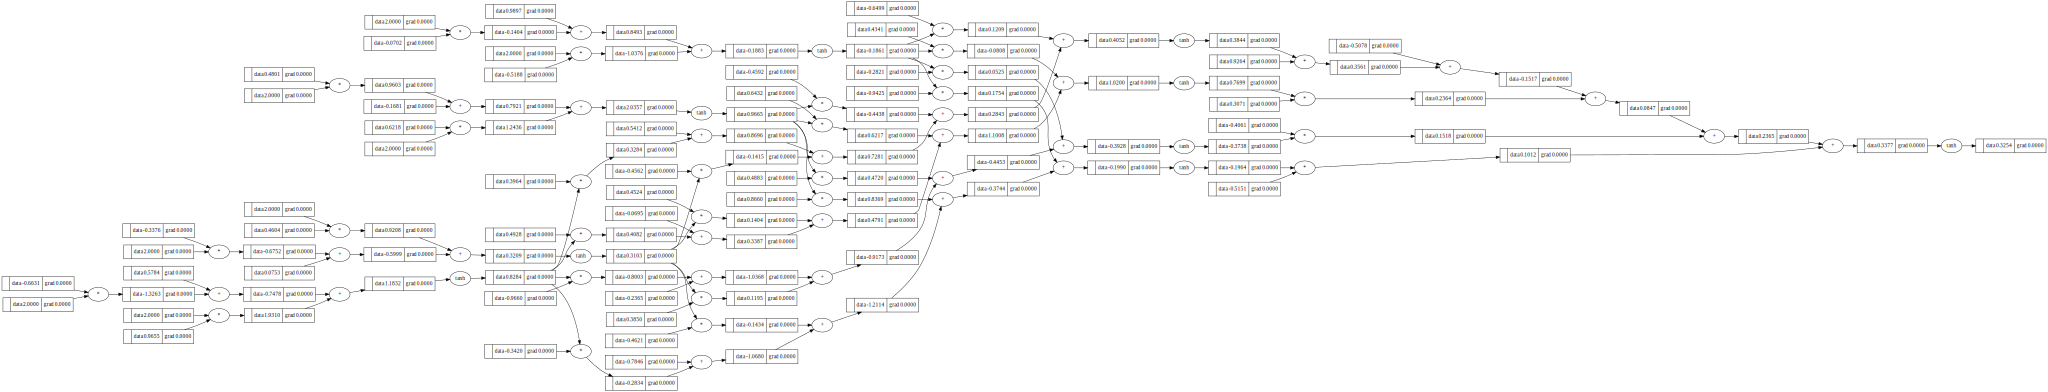

In [11]:
draw_dot(n(x))

In [12]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
[v.data for v in ypred]

[0.33172680610064603,
 -0.7523908996974278,
 0.35026751501112796,
 0.6676414378862278]

# **Example usage for training LR with MSE loss**



In [14]:
alpha = 0.1 # Learning rate

for k in range(20):
  ypred = [n(x) for x in xs]
  loss = sum([ (yout - ygt)**2 for ygt, yout in zip(ys, ypred) ]) # MSE loss

  for p in n.parameters():
    p.grad = 0
  loss.backward()

  #update
  for p in n.parameters():
    p.data -= alpha * p.grad

  print(f"epoch : {(k+1):02}  | current loss : {loss.data}")

epoch : 01  | current loss : 1.8326172415563406
epoch : 02  | current loss : 2.8607518821464035
epoch : 03  | current loss : 0.4785280900594733
epoch : 04  | current loss : 0.23645375049044598
epoch : 05  | current loss : 0.15600327257889052
epoch : 06  | current loss : 0.11789781486801695
epoch : 07  | current loss : 0.09457416506243542
epoch : 08  | current loss : 0.07877609293475192
epoch : 09  | current loss : 0.06735944742170531
epoch : 10  | current loss : 0.05872608217162304
epoch : 11  | current loss : 0.051973253833947776
epoch : 12  | current loss : 0.04655107962900992
epoch : 13  | current loss : 0.04210500599314682
epoch : 14  | current loss : 0.03839599508426664
epoch : 15  | current loss : 0.035256978366992195
epoch : 16  | current loss : 0.032567661421768576
epoch : 17  | current loss : 0.030239232926733493
epoch : 18  | current loss : 0.028204708199449667
epoch : 19  | current loss : 0.026412622412463706
epoch : 20  | current loss : 0.024822790872384565


In [15]:
[v.data for v in ypred]

[0.9204104272440508,
 -0.9742983248678463,
 -0.8947521649829147,
 0.9178379168927197]

In [16]:
loss = sum([ ( yout - ygt)**2 / ygt**2 for ygt, yout in zip(ys, ypred)])
MSPE = (loss / len(ys)) * 100
MSPE.data

0.6205697718096141